Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [1]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad



In [2]:
from openpyxl import load_workbook

def adjust_column_widths(excel_file):
    """
    Load an Excel workbook, adjust the column widths based on the maximum length of data in each column,
    and save the workbook.

    Parameters:
    - directory: str, the path to the directory containing the Excel file.
    - excel_file: str, the name of the Excel file to be processed.
    """
    # Load the workbook and select the active worksheet
    workbook = load_workbook(excel_file)
    worksheet = workbook.active

    # Adjust the column widths
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    workbook.save(excel_file)




In [3]:
def calculate_habitable_zone(T_eff, L_ratio):
    """
    Calculate the habitable zone boundary based on Kopparapu et al. (2013) Equations 2 & 3,
    using only the "Runaway Greenhouse" limit (Conservative inner boundary).
    
    Parameters:
    T_eff (float): Effective temperature of the star in Kelvin
    
    Returns:
    float: Distance of the habitable zone boundary in AU
    """

    T_sun = 5780  # Effective temperature of the Sun in Kelvin

    # Coefficients for "Runaway Greenhouse" from Table 3 in the paper
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]

    '''
    "Recent Venus": 
    S_eff_sun, a, b, c, d = [1.7753, 1.4316E-4, 2.9875E-9, -7.5702E-12, -1.1635E-15]
    "Runaway Greenhouse": 
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]
    "Moist Greenhouse":
    S_eff_sun, a, b, c, d = [1.0140, 8.1774E-5, 1.7063E-9, -4.3241E-12, -6.6462E-16]
    "Maximum Greenhouse":
    S_eff_sun, a, b, c, d = [0.3438, 5.8942E-5, 1.6558E-9, -3.0045E-12, -5.2983E-16]
    "Early Mars":
    S_eff_sun, a, b, c, d = [0.3179, 5.4513E-5, 1.5313E-9, -2.7786E-12, -4.8997E-16]
    '''

    T_star = T_eff - 5780
    S_eff = S_eff_sun + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    distance = np.sqrt(L_ratio / S_eff)
    
    return distance

### 1. Qeury Gaia DR2/3 data

names: https://gaia.aip.de/metadata/gaiadr3/gaia_source/

In [4]:
from astroquery.gaia import Gaia
import pandas as pd

# Define your DR2 query
query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
"""

# Execute the DR2 query
job_dr2 = Gaia.launch_job(query_dr2)
results_dr2 = job_dr2.get_results()

# Extract DR2 source IDs
dr2_source_ids = tuple(results_dr2['source_id'])

# Define the crossmatch query using the dr2_neighbourhood table
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job(crossmatch_query)
crossmatch_results = job_crossmatch.get_results()

# Define your DR3 query
query_dr3 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the DR3 query
job_dr3 = Gaia.launch_job(query_dr3)
results_dr3 = job_dr3.get_results()

# Convert results to pandas DataFrames for easier merging
df_dr2 = results_dr2.to_pandas()
df_crossmatch = crossmatch_results.to_pandas()
df_dr3 = results_dr3.to_pandas()

# Merge DR2 and crossmatch results
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')

# Merge the above result with DR3 results, prioritizing DR3 data
final_merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')

if 0:
  # Replace DR2 data with DR3 data where counterparts exist
  for col in df_dr3.columns:
      if col != 'source_id':
          final_merged_results[col] = final_merged_results[f'{col}_dr3'].combine_first(final_merged_results[f'{col}_dr2'])

  # Drop the duplicate columns
  final_merged_results = final_merged_results.drop(columns=[col for col in final_merged_results.columns if col.endswith('_dr2') or col.endswith('_dr3')])

# Print the final merged results
final_merged_results

,source_id_dr2,ra_dr2,dec_dr2,phot_g_mean_mag_dr2,phot_bp_mean_mag_dr2,phot_rp_mean_mag_dr2,parallax_dr2,teff_val,mass_flame_dr2,lum_flame_dr2,...,dec_dr3,phot_g_mean_mag_dr3,phot_bp_mean_mag_dr3,phot_rp_mean_mag_dr3,bp_rp,parallax_dr3,teff_gspphot,mass_flame_dr3,lum_flame_dr3,radius_flame
0,4.911306e+18,24.950579,-56.196402,5.604027,6.110481,5.017446,122.133341,5072.666504,0.772891,0.311397,...,-56.196400,5.625487,6.089998,4.995800,1.094198,122.003472,4902.265137,0.772891,0.311397,0.773601
1,4.911306e+18,24.951252,-56.193253,5.481575,5.975546,4.918038,122.055156,5083.000000,0.848425,0.332538,...,-56.193251,5.508302,5.956992,4.886207,1.070785,122.108813,5044.240234,0.848425,0.332538,0.755049
2,4.503795e+18,282.122332,10.743571,7.597579,8.204739,6.895321,59.262118,4802.333496,0.747773,0.235664,...,10.743510,7.606561,8.177541,6.885082,1.292459,59.234454,4542.218750,0.747773,0.235664,0.783907
3,4.038724e+18,271.599396,-36.019748,5.788329,6.125644,5.345592,58.125813,5922.000000,0.993722,1.041858,...,-36.019747,5.805398,6.107953,5.326963,0.780990,58.429633,5773.397461,0.993722,1.041858,1.020187
4,4.912581e+18,25.623353,-53.741285,5.354947,5.676978,4.966038,57.655586,6143.000000,1.074927,1.576709,...,-53.741300,5.383109,5.657312,4.946809,0.710503,57.640899,6011.648926,1.074927,1.576709,1.157568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.183967,8.941061,9.818028,8.020849,1.797179,66.200980,NaN,NaN,NaN,NaN
417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-32.069156,8.943901,9.798429,8.037454,1.760976,56.538080,3921.390137,NaN,0.096437,0.673637
418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.808281,8.950713,9.905321,7.981833,1.923489,72.893174,NaN,NaN,NaN,NaN
419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.553885,8.953956,9.869360,7.959608,1.909752,64.681011,NaN,NaN,NaN,NaN


In [5]:
# final_merged_results['dr2_source_id'][:338]  final_merged_results['dr3_source_id'][:338]

comparison = final_merged_results['dr2_source_id'][:338] == final_merged_results['dr3_source_id'][:338]
differences = final_merged_results[['dr2_source_id', 'dr3_source_id']][:338][~comparison]
print(f"Number of differences: {len(differences)}")
print("Differences:")
print(differences)

Number of differences: 166
Differences:
     dr2_source_id  dr3_source_id
55    3.575733e+18   3.575733e+18
124   1.462062e+18   1.462062e+18
156   3.943233e+18   3.943233e+18
175            NaN            NaN
176            NaN            NaN
..             ...            ...
333            NaN            NaN
334            NaN            NaN
335            NaN            NaN
336            NaN            NaN
337            NaN            NaN

[166 rows x 2 columns]


In [6]:
# Define the ADQL query
# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, parallax, teff_gspphot
# FROM gaiadr3.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""
'''
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
'''
# note: It's possible to include 
# "ap.mass_flame_lower, ap.mass_flame_upper" 
# in the SELECT statement to get the lower and upper bounds of the mass estimate

# note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218

# Execute the query
job = Gaia.launch_job(query)
query_dr3 = job.get_results()

# Print the results
query_dr3

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,parallax,teff_gspphot,mass_flame,lum_flame,radius_flame
,deg,deg,mag,mag,mag,mag,mas,K,solMass,solLum,solRad
int64,float64,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32
4683897617110115200,6.482504988433097,-77.25279546754571,2.6807318,3.2956264,2.371489,0.92413735,133.71940556671353,--,--,--,--
5698015743046182272,121.8856299797689,-24.304115553778075,2.7505891,3.302004,2.5121741,0.78982997,51.39988628348321,--,--,--,--
5826168461855385472,238.7838064740902,-63.43251144584002,2.784391,3.1869626,2.5581625,0.62880015,80.48541193436336,--,--,--,--
6838311796136238976,326.76139246141946,-16.128607188133948,2.836813,3.2903588,2.6031075,0.6872513,85.94055985093036,--,--,--,--
4269932382607207040,275.32505935876196,-2.9019428805540897,2.9904501,3.7105737,2.47357,1.2370036,52.44130794438597,--,--,--,--
1018776176872261248,143.20753978122536,51.67490604097004,3.0717425,3.5151834,2.686608,0.8285754,73.82839808283359,--,--,--,--
3288921720025503360,72.46212402119102,6.9613310085374644,3.0879216,3.513966,2.7081478,0.8058183,124.61980141424488,6154.11,1.208073,2.854192,1.4859011
1014058103758571520,134.7989643318015,48.040871471105525,3.120973,3.4182682,2.91068,0.50758815,68.00099930164292,7498.3286,1.6586772,9.631541,1.8388964


Quick check on the Luminosity-Radius-Temperature Relation

/Users/jinzhao/miniconda3/envs/tf/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


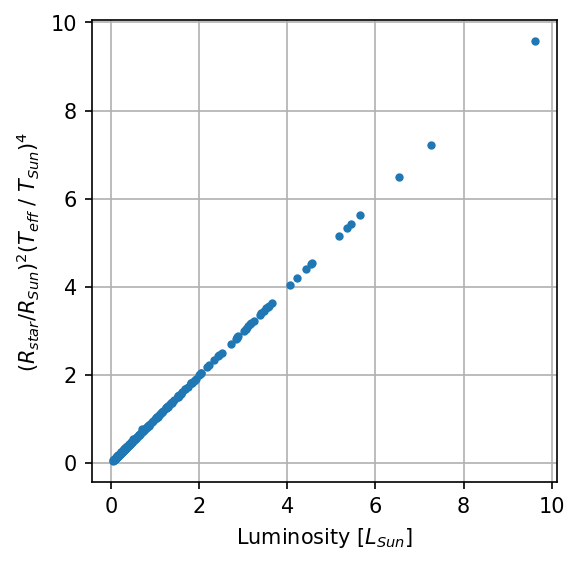

In [7]:
plt.figure(figsize=(4, 4), dpi=150) 
plt.plot(query_dr3['lum_flame'], (query_dr3['teff_gspphot']/5780)**4 * query_dr3['radius_flame']**2, '.')
plt.xlabel('Luminosity [$L_{Sun}$]')
plt.ylabel('$(R_{star}/R_{Sun})^2(T_{eff}$ / $T_{Sun})^4$')
plt.grid()

#### Query Gaia DR2

In [8]:
# Define the ADQL query

# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_val
# FROM gaiadr2.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
"""

# note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 325 to 172

# Execute the query
job = Gaia.launch_job(query)
query_dr2 = job.get_results()

# Print the results
query_dr2

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,teff_val,mass_flame,lum_flame
,deg,deg,mag,mag,mag,mas,K,solMass,solLum
int64,float64,float64,float32,float32,float32,float64,float32,float32,float32
4911306239828325760,24.95057933205967,-56.19640157291552,5.6040273,6.110481,5.017446,122.13334113520919,5072.6665,0.7728912,0.31139687
4911306239828325632,24.95125177735008,-56.193253444734914,5.4815745,5.975546,4.9180384,122.05515593526933,5083.0,0.848425,0.3325382
4503794795019024000,282.1223322844829,10.743571121256357,7.5975785,8.204739,6.895321,59.26211802631218,4802.3335,0.74777335,0.23566432
4038724053986441856,271.5993956729909,-36.019748261251586,5.7883286,6.125644,5.3455925,58.12581270135795,5922.0,0.9937225,1.0418576
4912580642524184960,25.623352566889793,-53.74128518649365,5.354947,5.6769776,4.966038,57.655586404793524,6143.0,1.0749273,1.5767086
4623036865373793408,84.29927979496259,-80.4646040515499,5.4906683,5.8385477,5.064284,54.70524180803885,5960.5,1.0258615,1.5354643
1234693112077610880,221.59652203947957,16.492729215598665,8.710161,9.476045,7.900152,56.320803206408755,4253.005,0.64877063,0.112481706
1264630412816366720,226.82615129468738,24.86848696167738,4.757479,5.0543466,4.467854,51.66743878315765,6567.0,1.284035,3.4606323


#### overlapping sources

OK... note that DR2 and DR3 may not share the same source_id, so estimate below is less than what it should be.

In [9]:
# Assuming query_dr3 is already obtained similarly to query_dr2

# Extract the source_id columns from both results
source_ids_dr2 = query_dr2['source_id']
source_ids_dr3 = query_dr3['source_id']

# Find the intersection of source_ids between DR2 and DR3
overlapping_source_ids = set(source_ids_dr2).intersection(set(source_ids_dr3))

# Print the overlapping source_ids
print(f"Number of overlapping source_ids: {len(overlapping_source_ids)}")
print(overlapping_source_ids)


Number of overlapping source_ids: 162
{1244571953471006720, 3575733210781078016, 5835498883232034816, 6171492113110925312, 5760701787150565888, 3865002247461685248, 4634528720388462592, 6018047019138644480, 1359938520253565952, 3724242219117947904, 6471497502884511232, 6009538585839374336, 3478127463341507072, 1605198298364601088, 5160075762132996992, 683184784030475520, 714116137767540096, 3101923001490347392, 5951165616611763456, 4745373133284418816, 746545172372256384, 2920772722738017920, 2904830113367963264, 4503794795019024000, 2473608009504466688, 1462061709995883136, 4038724053986441856, 6847167606385195648, 6490470881687779968, 1264630412816366720, 5808612830236138368, 3498481519515679872, 5726982995343100928, 5381537023379295232, 1833199729671740800, 70051608089857536, 4419140645978987904, 777254360337133312, 952326504452337792, 4467355158571184256, 3256786534197166208, 1821708351374312064, 892215482207937152, 2552925644460225152, 3852570413083923072, 4389844948935164544, 646

### 2. List star names and object types

In [10]:
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query to get Gaia source IDs
query = """
SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_gspphot
FROM gaiadr3.gaia_source
WHERE phot_g_mean_mag < 9
  AND dec BETWEEN -90 AND 60
  AND parallax >= 50
  AND (duplicated_source = 'false' OR duplicated_source IS NULL)
  AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Extract Gaia source IDs
source_ids = results['source_id']

# Dictionary to collect object types
object_types_collected = {}

# Query Simbad for each Gaia source ID and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids:
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

        # Collect object types
        if object_type not in object_types_collected:
            object_types_collected[object_type] = 0
        object_types_collected[object_type] += 1

        if hd_numbers:
            print(f"Gaia DR3 {source_id}: HD Number(s): {hd_numbers}, Object Type: {object_type}")
        elif gj_numbers:
            print(f"Gaia DR3 {source_id}: GJ Number(s): {gj_numbers}, Object Type: {object_type}")
        elif hip_numbers:
            print(f"Gaia DR3 {source_id}: HIP Number(s): {hip_numbers}, Object Type: {object_type}")
        else:
            print(f"Gaia DR3 {source_id}: No HD, GJ, or HIP number found, Object Type: {object_type}")
    else:
        print(f"No alternative names or object type found for Gaia DR3 {source_id}")

# Print all collected object types
print("\nCollected Object Types:")
for object_type, count in object_types_collected.items():
    print(f"{object_type}: {count}")


Gaia DR3 4683897617110115200: HD Number(s): ['HD   2151'], Object Type: HighPM*
Gaia DR3 5698015743046182272: HD Number(s): ['HD  67523'], Object Type: delSctV*
Gaia DR3 5826168461855385472: HD Number(s): ['HD 141891'], Object Type: HighPM*
Gaia DR3 6838311796136238976: HD Number(s): ['HD 207098'], Object Type: SB*
Gaia DR3 4269932382607207040: HD Number(s): ['HD 168723'], Object Type: HighPM*
Gaia DR3 1018776176872261248: HD Number(s): ['HD  82328'], Object Type: HighPM*
Gaia DR3 3288921720025503360: HD Number(s): ['HD  30652'], Object Type: HighPM*
Gaia DR3 1014058103758571520: GJ Number(s): ['GJ 331.0', 'GJ 331 A'], Object Type: SB*
Gaia DR3 5849837854861497856: HD Number(s): ['HD 128898'], Object Type: alf2CVnV*
Gaia DR3 4594497769766809216: HD Number(s): ['HD 161797', 'HD 161797A'], Object Type: **
Gaia DR3 3352485999058854912: HD Number(s): ['HD  48737'], Object Type: HighPM*
Gaia DR3 5164120762333028736: HD Number(s): ['HD  23249'], Object Type: HighPM*
Gaia DR3 2452378776434477


HighPM*: High Proper Motion Star. These stars have significant movement across the sky relative to more distant stars, indicating they are relatively close to Earth.

delSctV*: Delta Scuti Variable Star. These are pulsating variables with short periods of light variation, typically less than 0.3 days, found in the instability strip of the Hertzsprung-Russell diagram.

SB*: Spectroscopic Binary. A binary star system in which the stars are too close to be resolved individually but can be detected through their spectral lines.

alf2CVnV*: Alpha2 Canum Venaticorum Variable Star. These are chemically peculiar stars with strong magnetic fields and spectral lines that vary with the star's rotation.

**: Double or Multiple Star. A system of two or more stars that are gravitationally bound to each other.

BYDraV*: BY Draconis Variable Star. These are main-sequence variable stars showing light variations due to rotational modulation of star spots.

Variable*: Variable Star. A star whose brightness as seen from Earth fluctuates.

Eruptive*: Eruptive Variable Star. Stars that show sudden changes in brightness due to eruptions or flares.

RotV*: Rotational Variable Star. Stars whose brightness variations are due to rotation.

RSCVnV*: RS Canum Venaticorum Variable Star. These are close binary stars with active chromospheres, showing variations due to star spots and eclipses.

RGB*: Red Giant Branch Star. A star in a late phase of stellar evolution, characterized by expansion and cooling of the outer layers.

TTauri*: T Tauri Star. A very young star still in the process of gravitational contraction, often surrounded by a protoplanetary disk.

Star: A self-luminous celestial body consisting of a mass of gas held together by its own gravity.

EclBin: Eclipsing Binary. A binary star system where the orbital plane is aligned with our line of sight, causing the stars to eclipse each other.

Low-Mass*: Low-Mass Star. A star with a mass lower than approximately 0.5 solar masses, often including red dwarfs.

ChemPec*: Chemically Peculiar Star. Stars with unusual abundances of certain elements in their atmospheres.

### 3. Export to Excel

#### DR3

In [11]:
import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from openpyxl import load_workbook

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query to get Gaia source IDs
# query = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_gspphot
# FROM gaiadr3.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

'''
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
'''

# Execute the query
job = Gaia.launch_job(query)
results = job.get_results()

# Extract Gaia source IDs
source_ids = results['source_id']

# Initialize lists to store data
data = {
    'Gaia DR3 Source ID': [],
    'RA': [],
    'DEC': [],
    'Phot G Mean Mag': [],
    'Phot BP Mean Mag': [],
    'Phot RP Mean Mag': [],
    'Parallax': [],
    'T_eff [K]': [],
    'Mass [M_Sun]': [],
    'Luminosity [L_Sun]': [],
    'Radius [R_Sun]': [],
    'HD Number': [],
    'GJ Number': [],
    'HIP Number': [],
    'Object Type': []
}

# Query Simbad for each Gaia source ID and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids:
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

    data['Gaia DR3 Source ID'].append(str(source_id))  # Convert source_id to string
    data['RA'].append(results['ra'][source_ids == source_id][0])
    data['DEC'].append(results['dec'][source_ids == source_id][0])
    data['Phot G Mean Mag'].append(results['phot_g_mean_mag'][source_ids == source_id][0])
    data['Phot BP Mean Mag'].append(results['phot_bp_mean_mag'][source_ids == source_id][0])
    data['Phot RP Mean Mag'].append(results['phot_rp_mean_mag'][source_ids == source_id][0])
    data['Parallax'].append(results['parallax'][source_ids == source_id][0])
    data['T_eff [K]'].append(results['teff_gspphot'][source_ids == source_id][0])
    data['Mass [M_Sun]'].append(results['mass_flame'][source_ids == source_id][0])
    data['Luminosity [L_Sun]'].append(results['lum_flame'][source_ids == source_id][0])
    data['Radius [R_Sun]'].append(results['radius_flame'][source_ids == source_id][0])
    data['HD Number'].append(', '.join(hd_numbers) if hd_numbers else None)
    data['GJ Number'].append(', '.join(gj_numbers) if gj_numbers else None)
    data['HIP Number'].append(', '.join(hip_numbers) if hip_numbers else None)
    data['Object Type'].append(object_type)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
directory = '../results/'
excel_file = 'query_dr3.xlsx'
output_path = directory + excel_file
df.to_excel(output_path, index=False)

# Load the workbook and select the active worksheet
workbook = load_workbook(output_path)
worksheet = workbook.active

# Adjust the column widths
adjust_column_widths(output_path)


In [12]:
result_table = custom_simbad.query_object(f"Gaia DR3 {source_ids[0]}")
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,IDS,OTYPE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,object,int32
* bet Hyi,00 25 45.0703,-77 15 15.286,9,9,0.970,0.970,90,A,O,2007A&A...474..653V,LHS 6|* bet Hyi|CD-77 15|Ci 20 31|CNS5 125|CPC 21.3 43|CPD-77 16|CSV 100028|FAUST 12|FK5 11|GALAH 140708005801203|GC 503|GCRV 232|GEN# +1.00002151|GJ 19|HD 2151|HIC 2021|HIP 2021|HR 98|IRAS 00235-7731|JP11 381|LFT 43|LPM 22|LTT 226|2MASS J00254416-7715157|N30 76|NLTT 1346|NSV 161|PLX 69|PLX 69.00|PM 00232-7732|PPM 366918|1RXS J002543.0-771532|SAO 255670|SKY# 715|SPOCS 20|SV* ZI 21|TD1 212|TIC 267211065|TYC 9350-1626-1|UBV 309|UBV M 7368|uvby98 100002151|WEB 376|Zkh 9|Gaia DR2 4683897617108299136|Gaia DR3 4683897617110115200,HighPM*,1


In [13]:
if result_table is not None:
    ids = result_table['IDS'][0].split('|')
    hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
    gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
    hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
    object_type = result_table['OTYPE'][0]

hd_numbers, gj_numbers, hip_numbers, object_type

(['HD   2151'], ['GJ 19'], ['HIP 2021'], 'HighPM*')

#### DR2

In [14]:
import pandas as pd
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from openpyxl import load_workbook

# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Define the ADQL query for Gaia DR2
# query_dr2 = """
# SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax, teff_val
# FROM gaiadr2.gaia_source
# WHERE phot_g_mean_mag < 9
#   AND dec BETWEEN -90 AND 60
#   AND parallax >= 50
#   AND (duplicated_source = 'false' OR duplicated_source IS NULL)
#   AND (phot_bp_mean_mag - phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
# """

query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame, ap.radius_flame
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0

"""

'''
  AND ap.mass_flame IS NOT NULL
  AND ap.lum_flame IS NOT NULL
  AND ap.radius_flame IS NOT NULL
'''
# Execute the query for DR2
job_dr2 = Gaia.launch_job(query_dr2)
query_dr2 = job_dr2.get_results()

# Extract Gaia source IDs for DR2
source_ids_dr2 = query_dr2['source_id']

# Initialize lists to store data for DR2
data_dr2 = {
    'Gaia DR2 Source ID': [],
    'RA': [],
    'DEC': [],
    'Phot G Mean Mag': [],
    'Phot BP Mean Mag': [],
    'Phot RP Mean Mag': [],
    'Parallax': [],
    'T_eff [K]': [],
    'Mass [M_Sun]': [],
    'Luminosity [L_Sun]': [],
    'Radius [R_Sun]': [],
    'HD Number': [],
    'GJ Number': [],
    'HIP Number': [],
    'Object Type': []
}

# Query Simbad for each Gaia source ID in DR2 and filter for HD, GJ, and HIP numbers and object types
for source_id in source_ids_dr2:
    result_table = custom_simbad.query_object(f"Gaia DR2 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]

    data_dr2['Gaia DR2 Source ID'].append(str(source_id))  # Convert source_id to string
    data_dr2['RA'].append(query_dr2['ra'][source_ids_dr2 == source_id][0])
    data_dr2['DEC'].append(query_dr2['dec'][source_ids_dr2 == source_id][0])
    data_dr2['Phot G Mean Mag'].append(query_dr2['phot_g_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Phot BP Mean Mag'].append(query_dr2['phot_bp_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Phot RP Mean Mag'].append(query_dr2['phot_rp_mean_mag'][source_ids_dr2 == source_id][0])
    data_dr2['Parallax'].append(query_dr2['parallax'][source_ids_dr2 == source_id][0])
    data_dr2['T_eff [K]'].append(query_dr2['teff_val'][source_ids_dr2 == source_id][0])
    data_dr2['Mass [M_Sun]'].append(query_dr2['mass_flame'][source_ids_dr2 == source_id][0])
    data_dr2['Luminosity [L_Sun]'].append(query_dr2['lum_flame'][source_ids_dr2 == source_id][0])
    data_dr2['Radius [R_Sun]'].append(query_dr2['radius_flame'][source_ids_dr2 == source_id][0])
    data_dr2['HD Number'].append(', '.join(hd_numbers) if hd_numbers else None)
    data_dr2['GJ Number'].append(', '.join(gj_numbers) if gj_numbers else None)
    data_dr2['HIP Number'].append(', '.join(hip_numbers) if hip_numbers else None)
    data_dr2['Object Type'].append(object_type)

# Convert the data to a pandas DataFrame for DR2
df_dr2 = pd.DataFrame(data_dr2)

# Export the DataFrame to an Excel file for DR2
excel_file_dr2 = 'query_dr2.xlsx'
output_path_dr2 = directory + excel_file_dr2
df_dr2.to_excel(output_path_dr2, index=False)

# Load the workbook and select the active worksheet for DR2
workbook_dr2 = load_workbook(output_path_dr2)
worksheet_dr2 = workbook_dr2.active

# Adjust the column widths for DR2
adjust_column_widths(output_path_dr2)


#### Merging dr2 and dr3

In [15]:
# Load the DR2 and DR3 data from the Excel files
df_dr2 = pd.read_excel(directory + 'query_dr2.xlsx')
df_dr3 = pd.read_excel(directory + 'query_dr3.xlsx')

# Ensure that 'Gaia DR2 Source ID' and 'Gaia DR3 Source ID' are strings
df_dr2['Gaia DR2 Source ID'] = df_dr2['Gaia DR2 Source ID'].astype(str)
df_dr3['Gaia DR3 Source ID'] = df_dr3['Gaia DR3 Source ID'].astype(str)

# Merge the two DataFrames on 'source_id', keeping all entries
merged_df = pd.merge(df_dr2, df_dr3, left_on='Gaia DR2 Source ID', right_on='Gaia DR3 Source ID', suffixes=('_dr2', '_dr3'), how='outer')

# Replace '--' with NaN in the merged DataFrame
merged_df['T_eff [K]_dr3'] = merged_df['T_eff [K]_dr3'].replace("--", np.nan)
print("Merged DataFrame:")
display(merged_df)

combined_data = {
    'Source ID': merged_df['Gaia DR2 Source ID'].combine_first(merged_df['Gaia DR3 Source ID']).astype(str),
    'RA': merged_df['RA_dr3'].combine_first(merged_df['RA_dr2']),
    'DEC': merged_df['DEC_dr3'].combine_first(merged_df['DEC_dr2']),
    'Phot G Mean Mag': merged_df['Phot G Mean Mag_dr3'].combine_first(merged_df['Phot G Mean Mag_dr2']),
    'Phot BP Mean Mag': merged_df['Phot BP Mean Mag_dr3'].combine_first(merged_df['Phot BP Mean Mag_dr2']),
    'Phot RP Mean Mag': merged_df['Phot RP Mean Mag_dr3'].combine_first(merged_df['Phot RP Mean Mag_dr2']),
    'Parallax': merged_df['Parallax_dr3'].combine_first(merged_df['Parallax_dr2']),
    'T_eff [K]': merged_df['T_eff [K]_dr3'].combine_first(merged_df['T_eff [K]_dr2']),
    'Mass [M_Sun]': merged_df['Mass [M_Sun]_dr3'].combine_first(merged_df['Mass [M_Sun]_dr2']),
    'Luminosity [L_Sun]': merged_df['Luminosity [L_Sun]_dr3'].combine_first(merged_df['Luminosity [L_Sun]_dr2']),
    'Radius [R_Sun]': merged_df['Radius [R_Sun]_dr3'].combine_first(merged_df['Radius [R_Sun]_dr2']),
    'HD Number': merged_df['HD Number_dr3'].combine_first(merged_df['HD Number_dr2']),
    'GJ Number': merged_df['GJ Number_dr3'].combine_first(merged_df['GJ Number_dr2']),
    'HIP Number': merged_df['HIP Number_dr3'].combine_first(merged_df['HIP Number_dr2']),
    'Object Type': merged_df['Object Type_dr3'].combine_first(merged_df['Object Type_dr2']),
}

# Convert the combined data into a DataFrame
combined_df = pd.DataFrame(combined_data)

Merged DataFrame:


,Gaia DR2 Source ID,RA_dr2,DEC_dr2,Phot G Mean Mag_dr2,Phot BP Mean Mag_dr2,Phot RP Mean Mag_dr2,Parallax_dr2,T_eff [K]_dr2,Mass [M_Sun]_dr2,Luminosity [L_Sun]_dr2,...,Phot RP Mean Mag_dr3,Parallax_dr3,T_eff [K]_dr3,Mass [M_Sun]_dr3,Luminosity [L_Sun]_dr3,Radius [R_Sun]_dr3,HD Number_dr3,GJ Number_dr3,HIP Number_dr3,Object Type_dr3
0,6791154257817212672,319.937280,-26.354400,6.387894,6.758631,5.782233,54.790238,5209.226562,--,--,...,5.773308,54.028805,NaN,--,--,--,"HD 202940, HD 202940A","GJ 825.4 A, GJ 9734 A",HIP 105312,SB*
1,853820948481913472,157.604049,55.998989,8.081333,8.893318,7.230341,77.403214,4144.666504,--,--,...,7.220706,77.407233,NaN,--,--,--,HD 237903,GJ 394,NaN,HighPM*
2,4375233191015944192,261.435968,2.106322,6.926529,7.772230,6.056808,129.623123,4077.077393,--,--,...,6.047124,129.645882,NaN,--,--,--,HD 157881,GJ 673,HIP 85295,HighPM*
3,4911306239828325760,24.950579,-56.196402,5.604027,6.110481,5.017446,122.133341,5072.666504,0.772891,0.311397,...,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,HD 10361,GJ 66 A,NaN,HighPM*
4,4911306239828325632,24.951252,-56.193253,5.481575,5.975546,4.918038,122.055156,5083.000000,0.848425,0.332538,...,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,HD 10360,GJ 66 B,NaN,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.816618,69.256644,3831.621582,0.603023,0.080113,0.642275,HD 184489,GJ 763,HIP 96285,HighPM*
432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.872943,55.823794,3995.008301,--,0.115792,0.710162,HD 188807,GJ 773,HIP 98204,HighPM*
433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.831970,68.976245,NaN,--,--,--,NaN,GJ 334,HIP 44722,HighPM*
434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.050136,54.166711,3989.934326,--,0.101091,0.665358,HD 77175B,GJ 1120 B,NaN,HighPM*


Gaia only provides B, R and G-band magnitudes, but the RV precision tool uses the V-band magnitudes. I've found a conversion from this paper <https://iopscience.iop.org/article/10.3847/2041-8213/aacdf6/pdf> (Table 2) from Gaia DR2, which should also work for Gaia DR3.

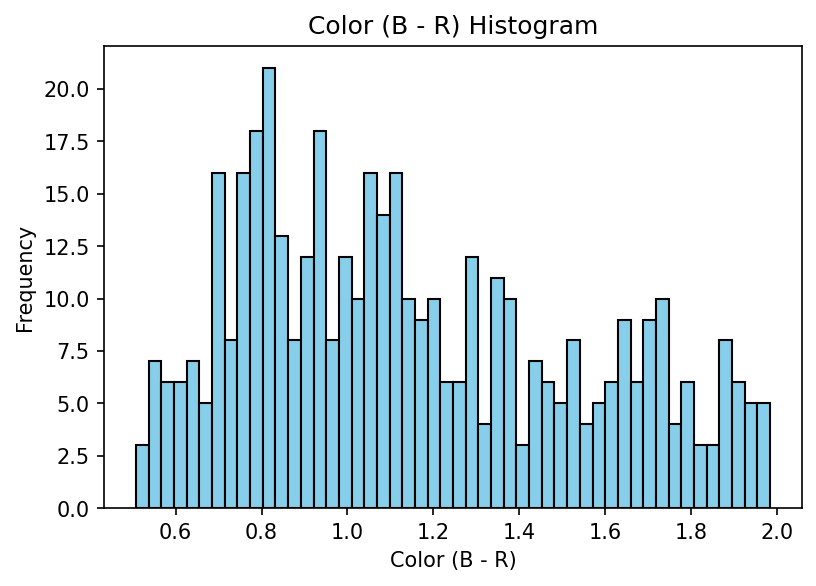

In [16]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Color (B - R)')
plt.ylabel('Frequency')
plt.title('Color (B - R) Histogram')
plt.savefig('../figures/color_histogram.png', dpi=300)  # Save the plot as a PNG file
plt.show()

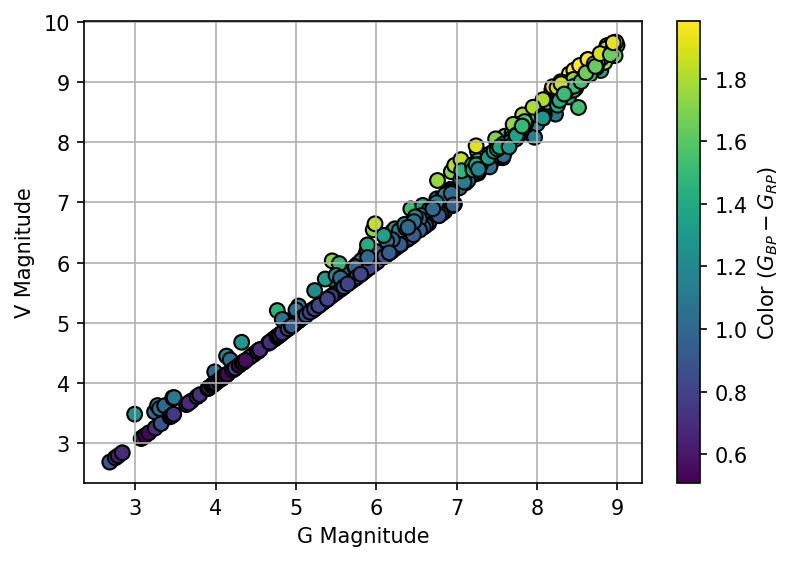

In [17]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
# plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color $(G_{BP} - G_{RP})$')
plt.grid()
plt.savefig('../figures/color_magnitude_diagram.png', dpi=300)
plt.show()


In [18]:
combined_df

,Source ID,RA,DEC,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,Parallax,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],HD Number,GJ Number,HIP Number,Object Type
0,6791154257817212672,319.937189,-26.354449,6.445514,6.742600,5.773308,54.028805,5209.226562,--,--,--,"HD 202940, HD 202940A","GJ 825.4 A, GJ 9734 A",HIP 105312,SB*
1,853820948481913472,157.604004,55.998984,8.084460,8.871609,7.220706,77.407233,4144.666504,--,--,--,HD 237903,GJ 394,NaN,HighPM*
2,4375233191015944192,261.435887,2.106158,6.934473,7.754755,6.047124,129.645882,4077.077393,--,--,--,HD 157881,GJ 673,HIP 85295,HighPM*
3,4911306239828325760,24.950657,-56.196400,5.625487,6.089998,4.995800,122.003472,4902.265137,0.772891,0.311397,0.773601,HD 10361,GJ 66 A,NaN,HighPM*
4,4911306239828325632,24.951317,-56.193251,5.508302,5.956992,4.886207,122.108813,5044.240234,0.848425,0.332538,0.755049,HD 10360,GJ 66 B,NaN,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,4291123545113039616,293.668338,4.583896,8.713564,9.552384,7.816618,69.256644,3831.621582,0.603023,0.080113,0.642275,HD 184489,GJ 763,HIP 96285,HighPM*
432,4188997606567280384,299.331417,-12.570278,8.729497,9.504207,7.872943,55.823794,3995.008301,--,0.115792,0.710162,HD 188807,GJ 773,HIP 98204,HighPM*
433,5743705394673617664,136.687588,-8.805906,8.787416,9.724067,7.831970,68.976245,NaN,--,--,--,NaN,GJ 334,HIP 44722,HighPM*
434,610304720935037184,135.322263,15.262939,8.914330,9.700054,8.050136,54.166711,3989.934326,--,0.101091,0.665358,HD 77175B,GJ 1120 B,NaN,HighPM*


In [19]:
# Insert the 'V_mag' column right after the 'DEC' column
combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

# if 'T_eff [K]' in combined_df.columns:

#     # Calculate the HZ_limit
#     hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)
#     # Find the index of the 'Radius [R_Sun]' column
#     radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
#     # Insert the new column after 'Radius [R_Sun]'
#     combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)
#     # Sort the DataFrame by temperature (Teff)
#     combined_df = combined_df.sort_values('T_eff [K]')    

# # Export the combined DataFrame to an Excel file
# combined_excel_file = 'combined_query.xlsx'
# output_path = directory + combined_excel_file
# combined_df.to_excel(output_path, index=False)

# print(f"Combined results saved to {output_path}")
# display(combined_df.head())

# # Adjust the column widths
# adjust_column_widths(output_path)

In [20]:
# Convert columns to numeric, forcing errors to NaN
combined_df['T_eff [K]'] = pd.to_numeric(combined_df['T_eff [K]'], errors='coerce')
combined_df['Luminosity [L_Sun]'] = pd.to_numeric(combined_df['Luminosity [L_Sun]'], errors='coerce')

# Check for NaN values and handle them (e.g., drop or fill)
if combined_df[['T_eff [K]', 'Luminosity [L_Sun]']].isnull().any().any():
    print("Warning: NaN values detected in 'T_eff [K]' or 'Luminosity [L_Sun]' columns.")
    # Option 1: Drop rows with NaN values
    combined_df.dropna(subset=['T_eff [K]', 'Luminosity [L_Sun]'], inplace=True)
    # Option 2: Fill NaN with a default value (e.g., mean or median)
    # combined_df['T_eff [K]'].fillna(combined_df['T_eff [K]'].mean(), inplace=True)
    # combined_df['Luminosity [L_Sun]'].fillna(combined_df['Luminosity [L_Sun]'].mean(), inplace=True)

# Calculate the HZ_limit
hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)

# Insert the new column after 'Radius [R_Sun]'
radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)

# Sort the DataFrame by temperature (Teff)
combined_df = combined_df.sort_values('T_eff [K]')

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


,Source ID,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,Parallax,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],HZ_limit [AU],HD Number,GJ Number,HIP Number,Object Type
89,2683023811628007296,330.540802,1.398992,9.136045,8.403359,9.387209,7.420015,94.563667,3501.576416,0.577452,0.066803,0.702667,0.276365,HD 209290,GJ 846,HIP 108782,HighPM*
6,3359074685047632640,99.291431,17.566317,9.604480,8.878268,9.855305,7.901706,100.023195,3503.495361,--,0.037894,0.528371,0.208142,HD 260655,GJ 239,HIP 31635,HighPM*
146,4282578724832056576,284.499690,5.902697,9.198853,8.460503,9.450294,7.471963,90.021153,3560.908936,0.586452,0.069564,0.692835,0.281779,HD 176029,GJ 740,HIP 93101,HighPM*
277,6673000841376349696,303.477391,-45.164731,7.940663,7.242661,8.190446,6.278736,162.217100,3588.520508,0.567104,0.061621,0.641908,0.265094,HD 191849,GJ 784,HIP 99701,HighPM*
106,1586968533015434624,225.232957,45.427733,9.132764,8.467483,9.381575,7.508891,85.411944,3601.680664,--,0.072812,0.693033,0.288103,NaN,GJ 572,HIP 73470,HighPM*


### 4. Generate the parameter file

In [21]:
# Not used because we need to split the input into hot and cool stars
if 0:

    import pandas as pd

    # Create a new DataFrame for parameter_file.csv
    parameter_df = pd.DataFrame({
        'Name': combined_df['Source ID'],
        'SpT': '',  # Empty column for SpT
        'Temperature': combined_df['T_eff [K]'],
        'Vmag': combined_df['V_mag'],
        'Jmag': ''  # Empty column for Jmag
    })

    # Save the new DataFrame to a CSV file
    output_path = directory + 'parameter_file.csv'
    parameter_df.to_csv(output_path, index=False)

    print(f"Parameter file has been saved as '{output_path}'")

    # Display the first few rows of the new DataFrame
    parameter_df.head()


In [22]:
import pandas as pd
import os

# Create a new DataFrame for parameter_file.csv
parameter_df = pd.DataFrame({
    'Name': combined_df['Source ID'],
    'SpT': '',  # Empty column for SpT
    'Temperature': combined_df['T_eff [K]'],
    'Vmag': combined_df['V_mag'],
    'Jmag': ''  # Empty column for Jmag
})

# Separate rows based on temperature; refer to email from Zechmeister
cool_stars = parameter_df[parameter_df['Temperature'] < 4000]
hot_stars = parameter_df[parameter_df['Temperature'] >= 4000]

# Save the DataFrames to CSV files
output_path_cool = os.path.join(directory, 'parameter_file_cool.csv')
output_path_hot = os.path.join(directory, 'parameter_file_hot.csv')

cool_stars.to_csv(output_path_cool, index=False)
hot_stars.to_csv(output_path_hot, index=False)

print(f"Cool stars (T < 4000K) file has been saved as '{output_path_cool}'")
print(f"Hot stars (T >= 4000K) file has been saved as '{output_path_hot}'")

# Print the number of stars in each category
print(f"\nNumber of cool stars (T < 4000K): {len(cool_stars)}")
print(f"Number of hot stars (T >= 4000K): {len(hot_stars)}")

# Save the original parameter_df to a CSV file
output_path_all = os.path.join(directory, 'parameter_file_all.csv')
parameter_df.to_csv(output_path_all, index=False)

print(f"\nAll stars file has been saved as '{output_path_all}'")

Cool stars (T < 4000K) file has been saved as '../results/parameter_file_cool.csv'
Hot stars (T >= 4000K) file has been saved as '../results/parameter_file_hot.csv'

Number of cool stars (T < 4000K): 41
Number of hot stars (T >= 4000K): 265

All stars file has been saved as '../results/parameter_file_all.csv'


### Now go and retrive the RV precision from Reiners' tool 
.

.

.


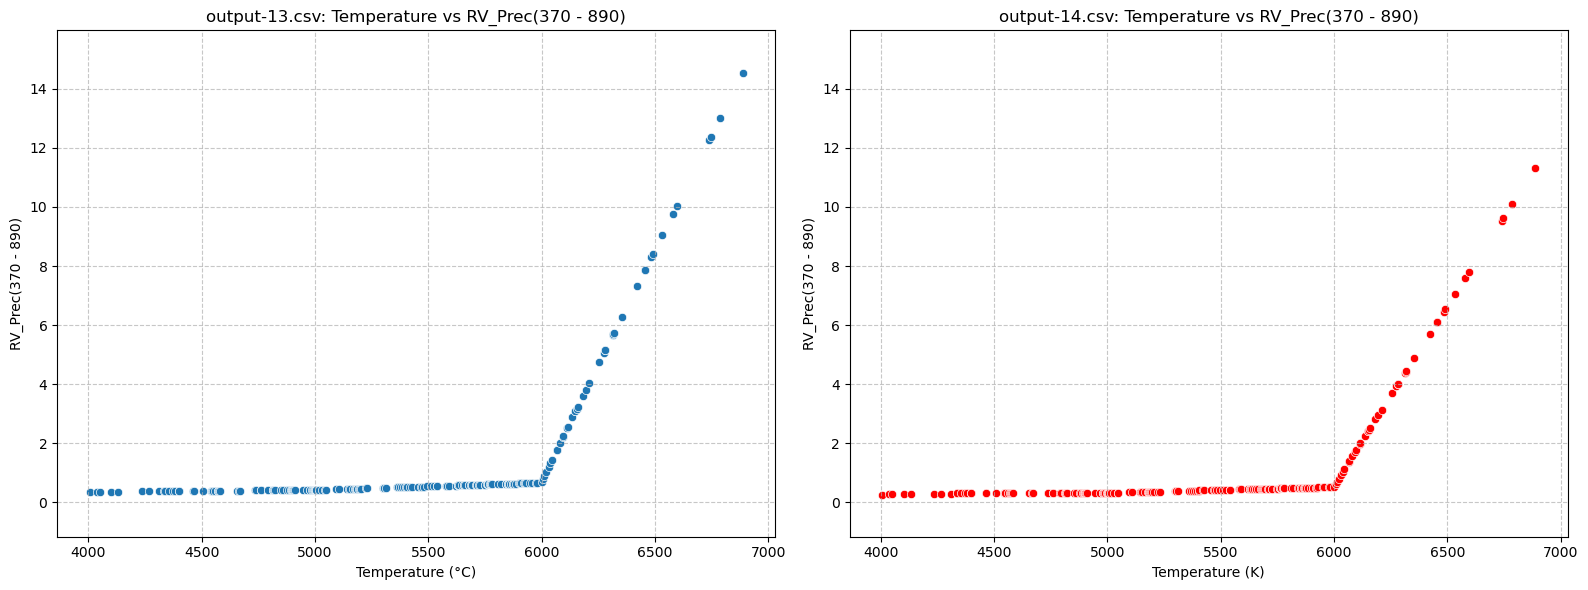


Statistics for output-13.csv:
       Temperature  RV_Prec(370 - 890)
count   204.000000          204.000000
mean   5434.354271            1.438080
std     643.194900            2.499872
min    4006.371826            0.338938
25%    4936.713745            0.408004
50%    5517.603760            0.542532
75%    5900.662476            0.637701
max    6887.404785           14.551520

Statistics for output-14.csv:
       Temperature  RV_Prec(370 - 890)
count   204.000000          204.000000
mean   5434.354271            1.117963
std     643.194900            1.943400
min    4006.371826            0.263490
25%    4936.713745            0.317182
50%    5517.603760            0.421765
75%    5900.662476            0.495749
max    6887.404785           11.312351

Correlation coefficient for output-13.csv: 0.6331
Correlation coefficient for output-14.csv: 0.6331


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV files
df_13 = pd.read_csv('/Users/jinzhao/Downloads/output_t_obs_30.csv')
df_14 = pd.read_csv('/Users/jinzhao/Downloads/output_SNR_100.csv')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for output-13.csv
sns.scatterplot(data=df_13, x='Temperature', y='RV_Prec(370 - 890)', ax=ax1)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('RV_Prec(370 - 890)')
ax1.set_title('output-13.csv: Temperature vs RV_Prec(370 - 890)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot for output-14.csv
sns.scatterplot(data=df_14, x='Temperature', y='RV_Prec(370 - 890)', ax=ax2, color='red')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('RV_Prec(370 - 890)')
ax2.set_title('output-14.csv: Temperature vs RV_Prec(370 - 890)')
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust y-axis limits to focus on the range of RV_Prec values
y_min = min(df_13['RV_Prec(370 - 890)'].min(), df_14['RV_Prec(370 - 890)'].min())
y_max = max(df_13['RV_Prec(370 - 890)'].max(), df_14['RV_Prec(370 - 890)'].max())
y_range = y_max - y_min
ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
ax2.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

plt.tight_layout()
plt.show()

# Print basic statistics
print("\nStatistics for output-13.csv:")
print(df_13[['Temperature', 'RV_Prec(370 - 890)']].describe())
print("\nStatistics for output-14.csv:")
print(df_14[['Temperature', 'RV_Prec(370 - 890)']].describe())

# Calculate correlation coefficients
corr_13 = df_13['Temperature'].corr(df_13['RV_Prec(370 - 890)'])
corr_14 = df_14['Temperature'].corr(df_14['RV_Prec(370 - 890)'])

print(f"\nCorrelation coefficient for output-13.csv: {corr_13:.4f}")
print(f"Correlation coefficient for output-14.csv: {corr_14:.4f}")

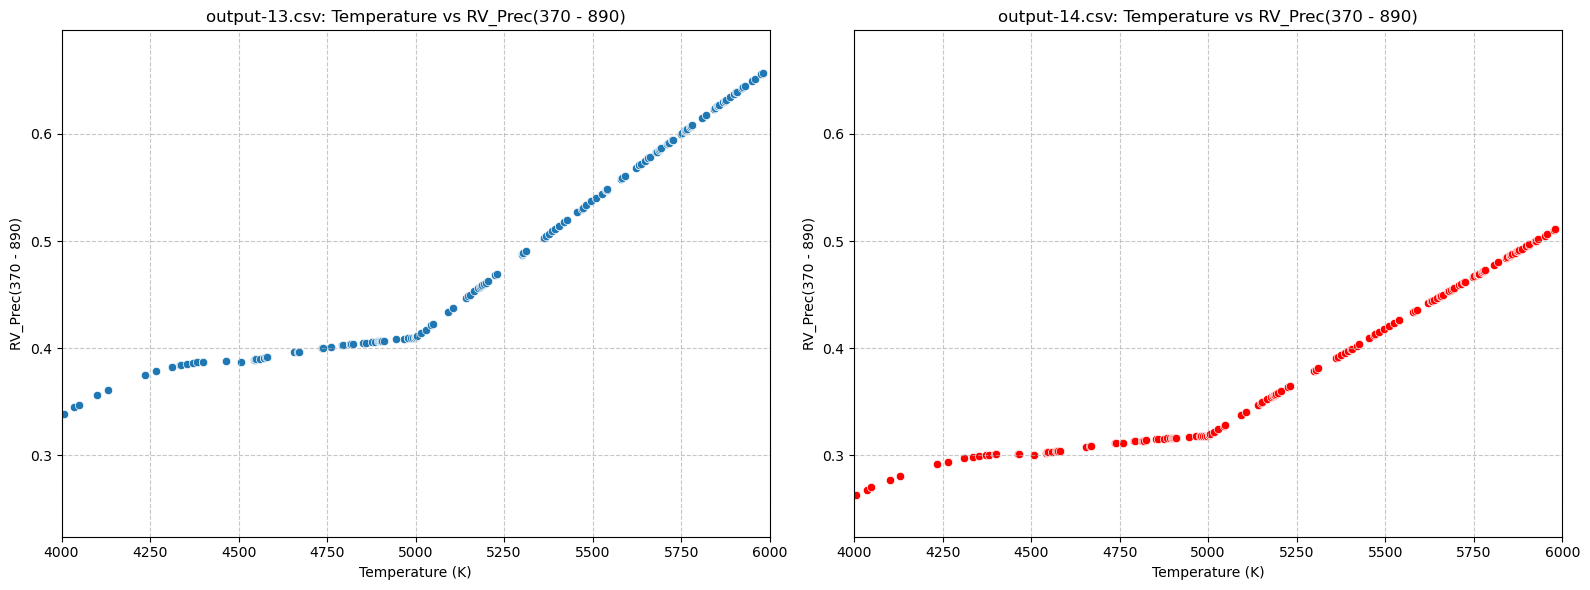


Statistics for output-13.csv (up to 6000 K):
       Temperature  RV_Prec(370 - 890)
count   162.000000          162.000000
mean   5215.549363            0.492417
std     522.733005            0.095294
min    4006.371826            0.338938
25%    4853.378174            0.405139
50%    5227.674072            0.468967
75%    5689.838989            0.585561
max    5980.538574            0.657326

Statistics for output-14.csv (up to 6000 K):
       Temperature  RV_Prec(370 - 890)
count   162.000000          162.000000
mean   5215.549363            0.382805
std     522.733005            0.074081
min    4006.371826            0.263490
25%    4853.378174            0.314955
50%    5227.674072            0.364575
75%    5689.838989            0.455215
max    5980.538574            0.511006

Correlation coefficient for output-13.csv (up to 6000 K): 0.9590
Correlation coefficient for output-14.csv (up to 6000 K): 0.9590


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV files
df_13 = pd.read_csv('/Users/jinzhao/Downloads/output_t_obs_30.csv')
df_14 = pd.read_csv('/Users/jinzhao/Downloads/output_SNR_100.csv')

# Filter data up to 6000 K
df_13_filtered = df_13[df_13['Temperature'] <= 6000]
df_14_filtered = df_14[df_14['Temperature'] <= 6000]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for output-13.csv
sns.scatterplot(data=df_13_filtered, x='Temperature', y='RV_Prec(370 - 890)', ax=ax1)
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('RV_Prec(370 - 890)')
ax1.set_title('output-13.csv: Temperature vs RV_Prec(370 - 890)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlim(4000, 6000)

# Plot for output-14.csv
sns.scatterplot(data=df_14_filtered, x='Temperature', y='RV_Prec(370 - 890)', ax=ax2, color='red')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('RV_Prec(370 - 890)')
ax2.set_title('output-14.csv: Temperature vs RV_Prec(370 - 890)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xlim(4000, 6000)

# Adjust y-axis limits to focus on the range of RV_Prec values
y_min = min(df_13_filtered['RV_Prec(370 - 890)'].min(), df_14_filtered['RV_Prec(370 - 890)'].min())
y_max = max(df_13_filtered['RV_Prec(370 - 890)'].max(), df_14_filtered['RV_Prec(370 - 890)'].max())
y_range = y_max - y_min
ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
ax2.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

plt.tight_layout()
plt.show()

# Print basic statistics for filtered data
print("\nStatistics for output-13.csv (up to 6000 K):")
print(df_13_filtered[['Temperature', 'RV_Prec(370 - 890)']].describe())
print("\nStatistics for output-14.csv (up to 6000 K):")
print(df_14_filtered[['Temperature', 'RV_Prec(370 - 890)']].describe())

# Calculate correlation coefficients for filtered data
corr_13 = df_13_filtered['Temperature'].corr(df_13_filtered['RV_Prec(370 - 890)'])
corr_14 = df_14_filtered['Temperature'].corr(df_14_filtered['RV_Prec(370 - 890)'])

print(f"\nCorrelation coefficient for output-13.csv (up to 6000 K): {corr_13:.4f}")
print(f"Correlation coefficient for output-14.csv (up to 6000 K): {corr_14:.4f}")

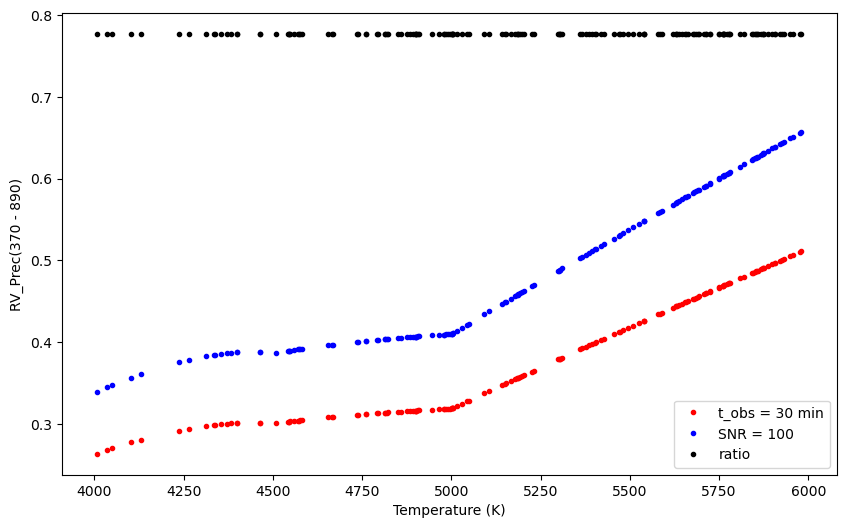

In [25]:
plt.subplots(figsize=(10, 6))
plt.plot(df_14_filtered['Temperature'], df_14_filtered['RV_Prec(370 - 890)'], '.', color='red', label='t_obs = 30 min')
plt.plot(df_13_filtered['Temperature'], df_13_filtered['RV_Prec(370 - 890)'], '.', color='blue', label='SNR = 100')
plt.plot(df_13_filtered['Temperature'], df_14_filtered['RV_Prec(370 - 890)']/ df_13_filtered['RV_Prec(370 - 890)'], '.', color='black', label='ratio')  
plt.xlabel('Temperature (K)')
plt.ylabel('RV_Prec(370 - 890)')
plt.legend()
# plt.savefig('', dpi=500)
plt.show()

### Merge RV_prec into query

In [26]:
# Read the RV precision CSV files
df_csv_cool = pd.read_csv(directory + 'output_cool.csv', dtype={'Id': str})
df_csv_hot = pd.read_csv(directory + 'output_hot.csv', dtype={'Id': str})

# Merge the dataframes
df_merged = pd.concat([df_csv_cool, df_csv_hot], ignore_index=True)

# Save the merged dataframe to a new CSV file
output_merged = os.path.join(directory, 'output_all.csv')
df_merged.to_csv(output_merged, index=False)


In [27]:
# Read the CSV file
# df_csv = pd.read_csv(directory + 'output_all.csv', dtype={'Id': str})

# Change notation
df_csv = df_merged

# Merge the dataframes based on the ID columns
merged_df = pd.merge(combined_df, df_csv[['Id', 'RV_Prec(370 - 890)']], left_on='Source ID', right_on='Id', how='outer')

# Clean up and rename columns
merged_df = merged_df.drop(columns=['Id'])
merged_df = merged_df.rename(columns={'RV_Prec(370 - 890)': 'RV precision [m/s]'})

# Reorder columns to put "RV precision" next to "HZ_limit [AU]"
cols        = merged_df.columns.tolist()
hz_index    = cols.index("HZ_limit [AU]")
cols.insert(hz_index + 1, cols.pop(cols.index("RV precision [m/s]")))
merged_df   = merged_df[cols]

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated Excel file has been saved as '{output_path}'")


Updated Excel file has been saved as '../results/combined_query_with_RV_precision.xlsx'


### Calculate the HZ mass detection limit

In [28]:
from scipy import optimize

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_earth = 5.97e24  # Earth mass in kg
M_sun = 1.989e30  # Solar mass in kg
AU = 1.496e11  # 1 AU in meters

def calculate_hz_detection_limit(K, stellar_mass, orbital_radius):
    """
    Calculate the minimum detectable planet mass in the Habitable Zone.
    
    :param K: RV precision in m/s
    :param stellar_mass: Mass of the star in solar masses
    :param orbital_radius: Orbital radius (HZ limit) in AU
    :return: Minimum detectable planet mass in Earth masses or np.nan if calculation fails
    """
    try:
        stellar_mass_kg = stellar_mass * M_sun
        orbital_radius_m = orbital_radius * AU
        
        if K <= 0 or stellar_mass_kg <= 0 or orbital_radius_m <= 0:
            return np.nan
        
        def equation(m_p):
            return K - (G**(1/2) * orbital_radius_m**(-1/2) * m_p * (stellar_mass_kg + m_p)**(-1/2))
        
        # Use numerical method to solve the equation
        planet_mass_kg = optimize.brentq(equation, 0, stellar_mass_kg)
        
        return planet_mass_kg / M_earth
    except:
        return np.nan

# Apply the calculation to each row
merged_df['HZ Detection Limit [Earth Mass]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [Earth Mass]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [Earth Mass]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [Earth Mass]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    227.000000
mean      17.427509
std       39.949459
min        0.696548
25%        2.535107
50%        4.047428
75%        6.703279
max      251.059908
Name: HZ Detection Limit [Earth Mass], dtype: float64
Number of NaN values: 79
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


In [29]:
merged_df

,Source ID,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,Parallax,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],HZ_limit [AU],RV precision [m/s],HZ Detection Limit [Earth Mass],HD Number,GJ Number,HIP Number,Object Type
0,2683023811628007296,330.540802,1.398992,9.136045,8.403359,9.387209,7.420015,94.563667,3501.576416,0.577452,0.066803,0.702667,0.276365,0.155899,0.696548,HD 209290,GJ 846,HIP 108782,HighPM*
1,3359074685047632640,99.291431,17.566317,9.604480,8.878268,9.855305,7.901706,100.023195,3503.495361,--,0.037894,0.528371,0.208142,NaN,NaN,HD 260655,GJ 239,HIP 31635,HighPM*
2,4282578724832056576,284.499690,5.902697,9.198853,8.460503,9.450294,7.471963,90.021153,3560.908936,0.586452,0.069564,0.692835,0.281779,0.168866,0.767748,HD 176029,GJ 740,HIP 93101,HighPM*
3,6673000841376349696,303.477391,-45.164731,7.940663,7.242661,8.190446,6.278736,162.217100,3588.520508,0.567104,0.061621,0.641908,0.265094,0.174864,0.758294,HD 191849,GJ 784,HIP 99701,HighPM*
4,1586968533015434624,225.232957,45.427733,9.132764,8.467483,9.381575,7.508891,85.411944,3601.680664,--,0.072812,0.693033,0.288103,NaN,NaN,NaN,GJ 572,HIP 73470,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,3683687763520080384,190.412427,-1.449023,3.433299,3.433299,3.512801,2.914254,83.193478,6740.179199,1.384102,4.551783,1.564594,1.960774,10.659935,196.449511,"HD 110379J, HD 110379","GJ 482.0, GJ 482 A",HIP 61941,HighPM*
302,3526420114274019456,188.015645,-16.196264,4.209557,4.209557,4.391628,3.865172,54.813472,6746.528320,1.416257,5.173365,1.664822,2.089624,10.745435,206.790357,HD 109085,"GJ 9411, GJ 471.2",HIP 61174,HighPM*
303,5205029672996886016,156.098524,-74.031737,3.909765,3.909765,4.088212,3.570792,61.434166,6786.989746,1.434542,5.450182,1.68849,2.139967,11.290282,221.294952,HD 90589,GJ 391,HIP 50954,Variable*
304,2995725777563537792,89.101033,-14.167081,3.635856,3.635856,3.854462,3.315019,66.857338,6887.404785,1.454221,5.649169,1.669571,2.166873,12.642324,251.059908,HD 40136,GJ 225,HIP 28103,HighPM*


### Statistics and plots

In [30]:
print(merged_df.columns.tolist())

['Source ID', 'RA', 'DEC', 'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']


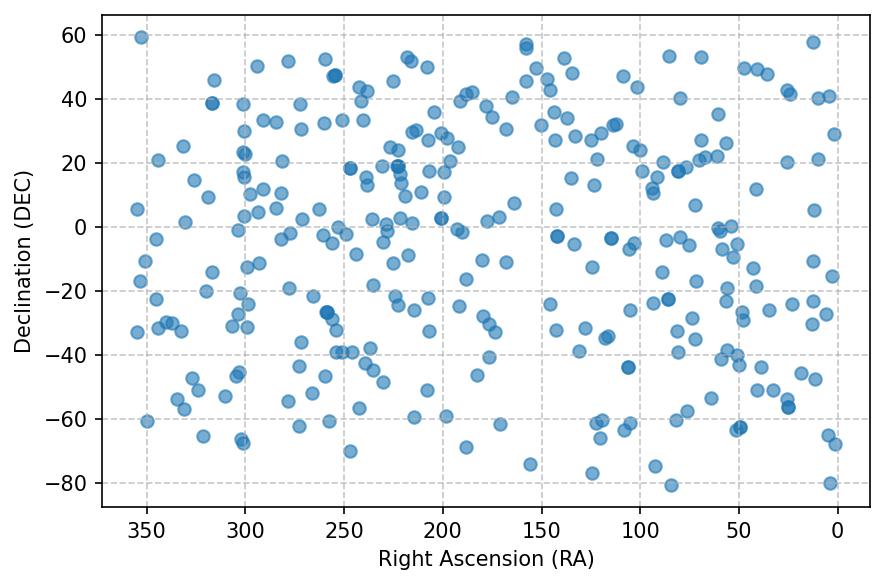

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(merged_df['RA'], merged_df['DEC'], alpha=0.6)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
plt.grid(True, linestyle='--', alpha=0.7)

# Invert the x-axis to match astronomical convention (RA increases to the left)
plt.gca().invert_xaxis()

plt.tight_layout()
plt.savefig('../figures/ra_dec.png', dpi=300)
plt.show()


ValueError: could not convert string to float: '--'

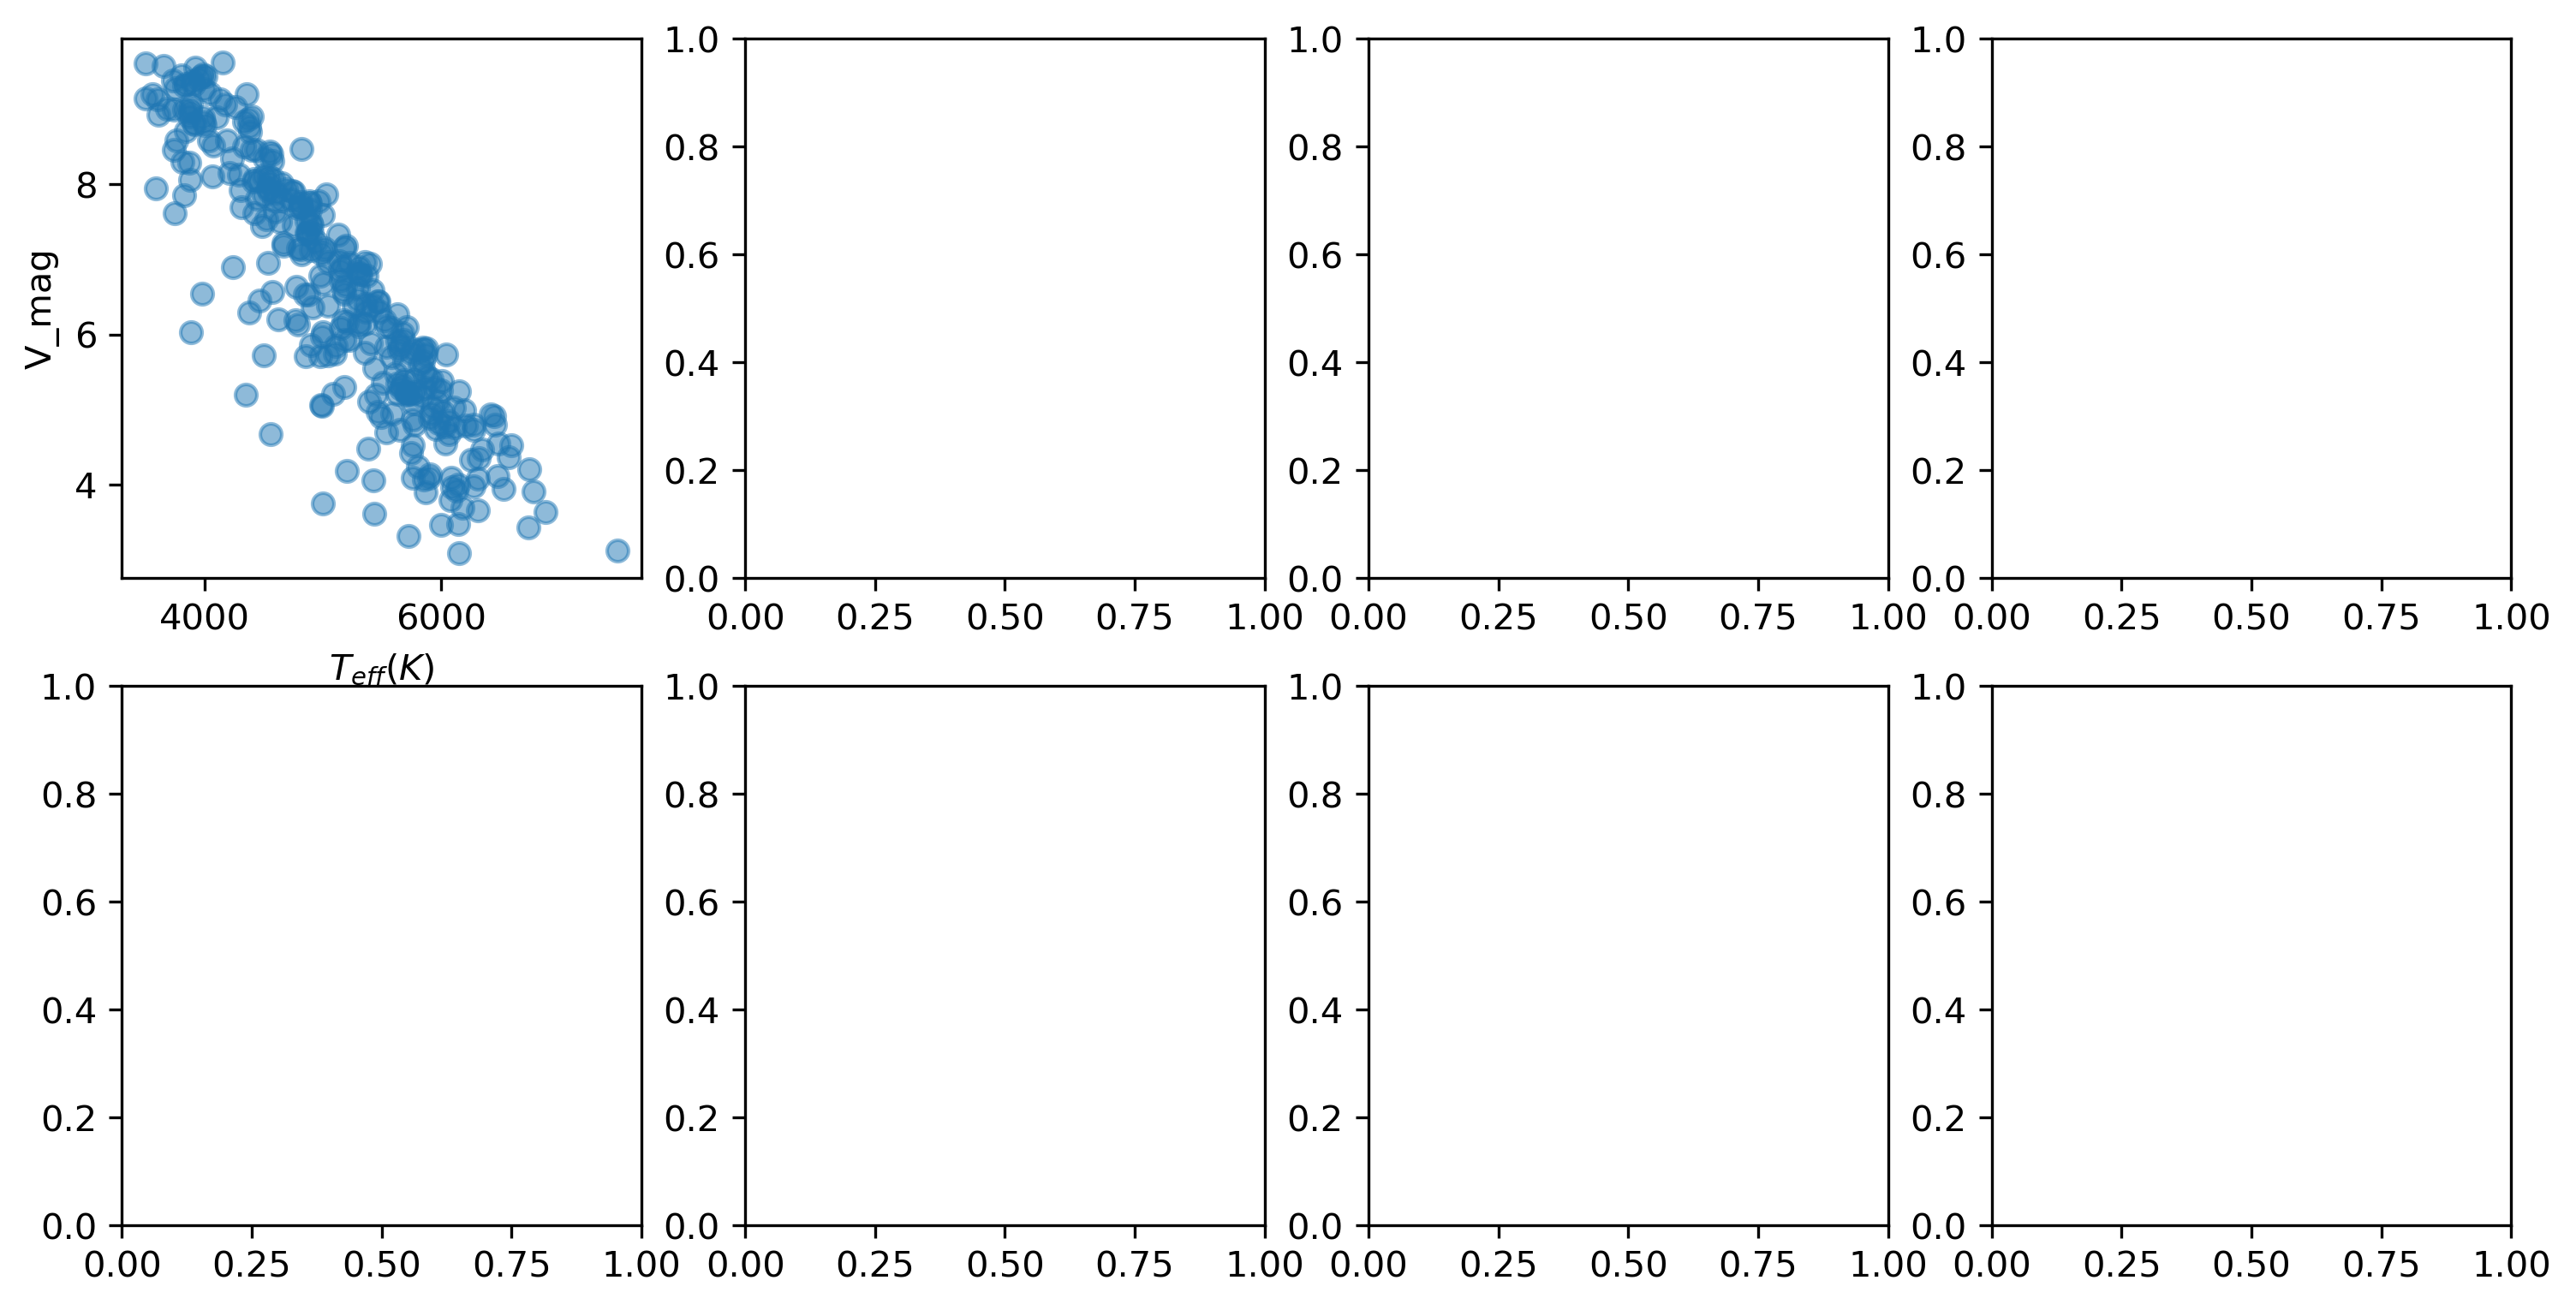

In [33]:
# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)
# fig.suptitle('Stellar Properties as a Function of Temperature', fontsize=16)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# List of columns to plot
columns = ['V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]']

# Plot each column
for i, col in enumerate(columns):
    axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.5)
    axs[i].set_xlabel('$T_{eff} (K)$')
    axs[i].set_ylabel(col)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('../figures/stellar_properties_vs_temperature.png')
plt.show()


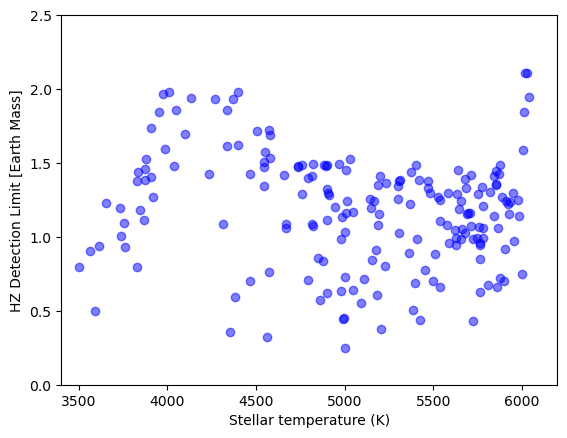

In [29]:
plt.plot(merged_df['T_eff [K]'], merged_df['HZ Detection Limit [Earth Mass]'], 'o', color='blue', label='RV precision', alpha=0.5)
plt.xlabel('Stellar temperature (K)')
plt.ylabel('HZ Detection Limit [Earth Mass]')
plt.xlim(min(merged_df['T_eff [K]'])-100, 6000+200)
plt.ylim(0, 2.5)
plt.show()

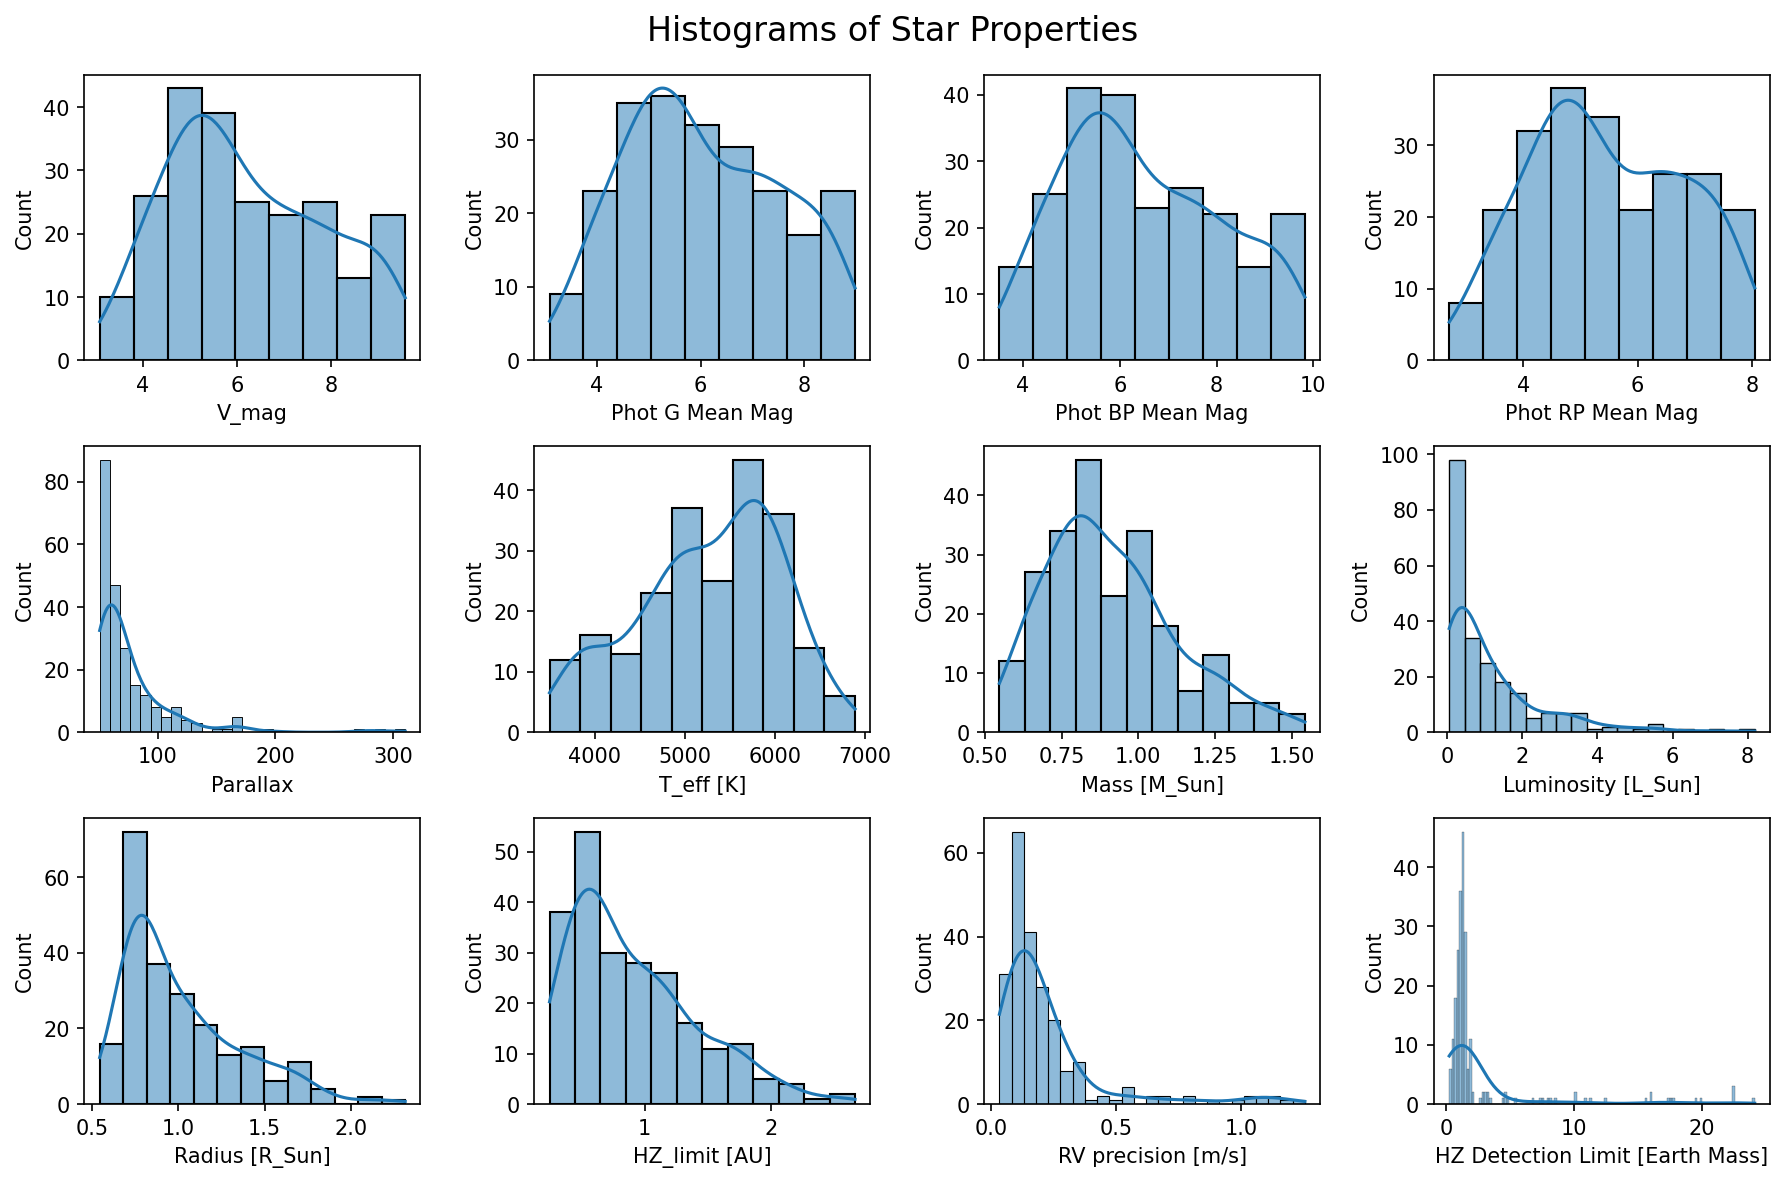

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot
columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]'
]

# Set up the plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=150)
fig.suptitle('Histograms of Star Properties', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=merged_df, x=column, kde=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('../figures/star_properties_histograms.png')
plt.show()


# additional codes (not used for now)

In [17]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.1, u.deg)
height = u.Quantity(0.1, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
r
# r.pprint(max_lines=12, max_width=130)

INFO: Query finished. [astroquery.utils.tap.core]


dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,
float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,fl

In [5]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from astropy import units as u
from astropy_healpix import HEALPix

In [6]:
# Set input parameters below ===========
DR3            = True            # Set it to False to select EDR3
target_table   = 'gaia_source'   # Alternative values: 'Astrophysical_parameters/astrophysical_parameters/', etc
hpx_level      = 6
lon            =  80.894 * u.deg # Right Ascencion (ICRS)
lat            = -69.756 * u.deg # Declination (ICRS)
radius         = 0.5     * u.deg

print(f'Input Variables: ')
print(f'* HEALPix level                      = {hpx_level} ')
print(f'* ICRS longitude (~ Right Ascension) = {lon} ')
print(f'* ICRS latitude  (~ Declination)     = {lat} ')
print(f'* Radius                             = {radius} ')
print()

Input Variables: 
* HEALPix level                      = 6 
* ICRS longitude (~ Right Ascension) = 80.894 deg 
* ICRS latitude  (~ Declination)     = -69.756 deg 
* Radius                             = 0.5 deg 



In [7]:
# Download basic parameters ============
output_file    = 'bulk_download_files.txt'
output_dir     = 'downloads'

if os.path.isdir(f'{output_dir}'):
    now          = datetime.now()
    output_dir_2 = output_dir + now.strftime("_%Y-%m-%d")
    print(f'>> Warning: {output_dir} directory exist. Creating alternative directory: {output_dir_2}')
    print()
    output_dir   = output_dir_2
else:
    os.system(f'mkdir {output_dir}')

print(f'Files will be downloaded to: {output_dir}')

Files will be downloaded to: downloads
